In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


In [2]:
n_future = 20

# Convert series to supervised learning
def series_to_supervised(data, n_in=5, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [3]:
# Load dataset
dataset = pd.read_csv('technical_indicators/BHP/DBP/BHPDBP.csv', header=0, index_col=0)
## df1=dataset.iloc[:,[1,2,3,4,5,6]]
values = dataset.values
values = values.astype('float32')

# Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# Reframe as supervised learning
reframed = series_to_supervised(scaled, 7, 2)
print(reframed.head())
print(reframed.shape)

# For n_in=14, n_future=20
print(reframed.head())
print(reframed.shape)


    var1(t-7)  var2(t-7)  var3(t-7)  var4(t-7)  var5(t-7)  var6(t-7)  \
7    0.277301   0.310842   0.509504   0.467660   0.156915   0.290530   
8    0.535301   0.277301   0.310842   0.509504   0.248817   0.539708   
9    0.381652   0.535301   0.277301   0.310842   0.152056   0.414301   
10   0.475877   0.381652   0.535301   0.277301   0.000000   0.448283   
11   0.503781   0.475877   0.381652   0.535301   0.048435   0.463486   

    var7(t-7)  var8(t-7)  var9(t-7)  var10(t-7)  ...  var20(t+1)  var21(t+1)  \
7    0.306116   0.419790   0.565398    0.192608  ...    0.013714    0.738691   
8    0.458814   0.513149   0.590324    0.156915  ...    0.015006    0.694801   
9    0.556930   0.525917   0.564099    0.248817  ...    0.016675    0.547718   
10   0.490605   0.664739   0.611146    0.152056  ...    0.018211    0.621940   
11   0.569747   0.646821   0.750490    0.000000  ...    0.019624    0.571156   

    var22(t+1)  var23(t+1)  var24(t+1)  var25(t+1)  var26(t+1)  var27(t+1)  \
7     0.

In [5]:
# Split into train and test sets
values = reframed.values
train = values[:1079, :]
test = values[1080:, :]

# Split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# Reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
# We reshaped the input into the 3D format as expected by MLP, namely [samples, timesteps, features].

(1079, 1, 260) (1079,) (221, 1, 260) (221,)


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define MLP Model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size=1):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_sizes[2], output_size)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        x = self.fc4(x)  # No activation in output layer (regression task)
        return x

# Initialize MLP Model
hidden_layers = [64, 32, 16]  # Define hidden layer sizes
model = MLP(input_size=train_X.shape[2], hidden_sizes=hidden_layers).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Print model summary
print(model)


MLP(
  (fc1): Linear(in_features=260, out_features=64, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (relu3): ReLU()
  (fc4): Linear(in_features=16, out_features=1, bias=True)
)


/Users/rishithakalicheti/anaconda3/envs/bigdml/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1079])) that is different to the input size (torch.Size([1079, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/rishithakalicheti/anaconda3/envs/bigdml/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([221])) that is different to the input size (torch.Size([221, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [50/500], Train Loss: 0.023818, Test Loss: 0.025425
Epoch [100/500], Train Loss: 0.023543, Test Loss: 0.025352
Epoch [150/500], Train Loss: 0.023440, Test Loss: 0.025310
Epoch [200/500], Train Loss: 0.023405, Test Loss: 0.025299
Epoch [250/500], Train Loss: 0.023392, Test Loss: 0.025301
Epoch [300/500], Train Loss: 0.023385, Test Loss: 0.025305
Epoch [350/500], Train Loss: 0.023382, Test Loss: 0.025308
Epoch [400/500], Train Loss: 0.023379, Test Loss: 0.025309
Epoch [450/500], Train Loss: 0.023377, Test Loss: 0.025310
Epoch [500/500], Train Loss: 0.023375, Test Loss: 0.025310

Final Train Loss: 0.023375
Final Test Loss: 0.025310


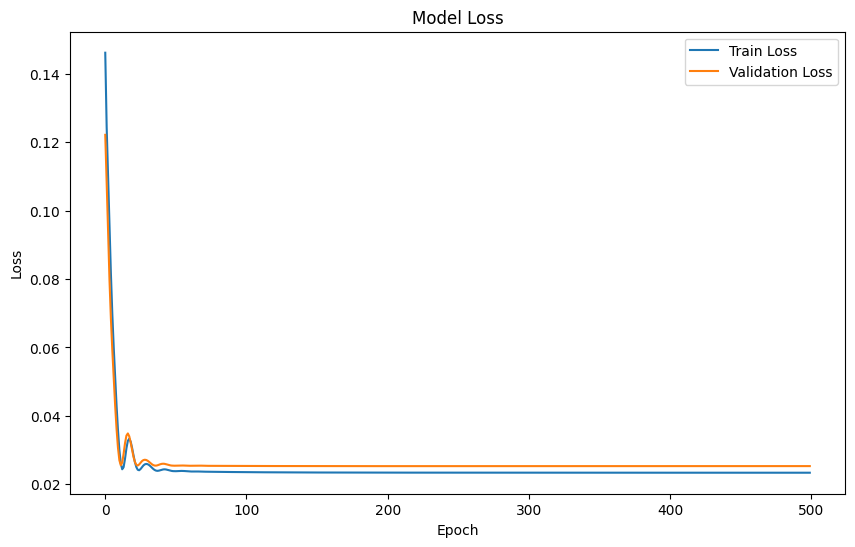

In [10]:
train_X_tensor = torch.tensor(train_X, dtype=torch.float32).to(device)
train_y_tensor = torch.tensor(train_y, dtype=torch.float32).to(device)
test_X_tensor = torch.tensor(test_X, dtype=torch.float32).to(device)
test_y_tensor = torch.tensor(test_y, dtype=torch.float32).to(device)

# Training Loop
epochs = 500
batch_size = 64
train_losses = []
test_losses = []

for epoch in range(epochs):
    model.train()  # Set to training mode
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(train_X_tensor)
    loss = criterion(outputs, train_y_tensor)
    
    # Backward pass
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        test_outputs = model(test_X_tensor)
        test_loss = criterion(test_outputs, test_y_tensor)

    # Store losses
    train_losses.append(loss.item())
    test_losses.append(test_loss.item())

    # Print progress every 50 epochs
    if (epoch + 1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.6f}, Test Loss: {test_loss.item():.6f}")

# Final Loss
print(f"\nFinal Train Loss: {train_losses[-1]:.6f}")
print(f"Final Test Loss: {test_losses[-1]:.6f}")

# Plot Training & Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Validation Loss')
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()


In [18]:
# Ensure model is in evaluation mode
model.eval()

# Convert test data to PyTorch tensor and move to device
test_X_tensor = torch.tensor(test_X, dtype=torch.float32).to(device)

# Make predictions
with torch.no_grad():
    yhat = model(test_X_tensor)

# Convert predictions back to NumPy
yhat = yhat.cpu().numpy()
yhat = yhat.reshape(-1, 1)

# Reshape test_X to match the concatenation shape
test_X_reshaped = test_X.reshape((test_X.shape[0], test_X.shape[2]))

yhat = np.asarray(yhat)
test_X_reshaped = np.asarray(test_X_reshaped)

print(yhat.shape, test_X_reshaped.shape)

# Invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X_reshaped[:, -28:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]  # Extract the first column

# Invert scaling for actual values
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X_reshaped[:, -28:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]  # Extract the first column

# Calculate Performance Metrics
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
r2 = r2_score(inv_y, inv_yhat)
mae = mean_absolute_error(inv_y, inv_yhat)
mse = mean_squared_error(inv_y, inv_yhat)

# Print metrics
print(f"Test RMSE: {rmse:.3f}")
print(f"R2 Score: {r2:.3f}")
print(f"MAE: {mae:.3f}")
print(f"MSE: {mse:.3f}")

# Display Predictions

df_predictions = pd.DataFrame({
    "Actual": inv_y,
    "Predicted": inv_yhat
})
print(df_predictions.head())



(221, 1) (221, 260)
Test RMSE: 0.082
R2 Score: 0.005
MAE: 0.062
MSE: 0.007
     Actual  Predicted
0  0.010998  -0.147687
1 -0.109120  -0.147591
2 -0.109120  -0.147829
3 -0.229238  -0.146798
4 -0.109120  -0.148290


In [19]:
# Calculate MAPE
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

print('MAPE: ', mean_absolute_percentage_error(test_y, yhat))

MAPE:  67.62772886466016


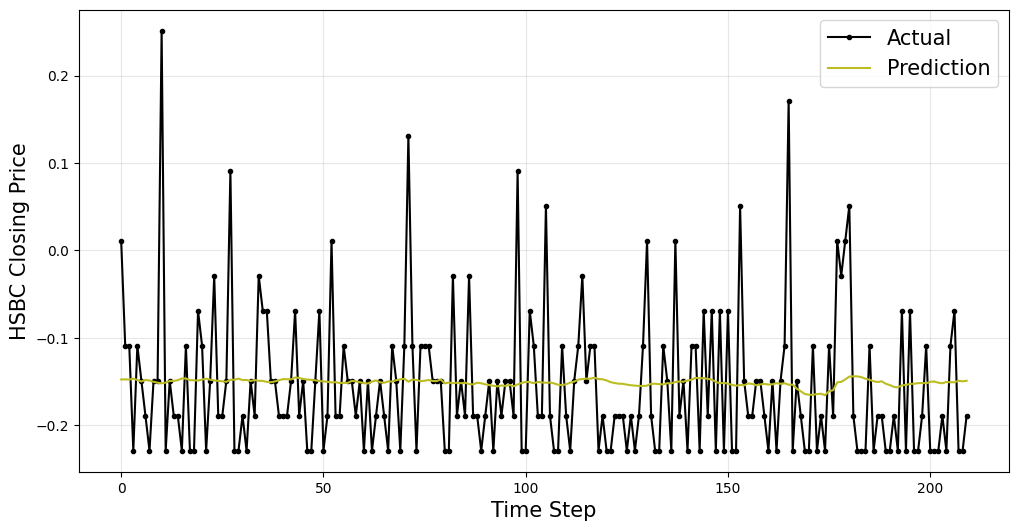

In [20]:
plt.figure(figsize=(12, 6))
aa = [x for x in range(210)]
plt.plot(aa, inv_y[:210], marker='.', color='black', label="Actual")
plt.plot(aa, inv_yhat[:210], 'tab:olive', label="Prediction")
plt.ylabel('HSBC Closing Price', size=15)
plt.xlabel('Time Step', size=15)
plt.legend(fontsize=15)
plt.grid(True, alpha=0.3)
plt.show()

In [23]:
# Generate future predictions
a = values[-n_future:,:-1]
a = a.reshape(a.shape[0], 1, -1)

a_tensor = torch.tensor(a, dtype=torch.float32).to(device)
with torch.no_grad():
    forecast = model(a_tensor)
# forecast = model.predict(a)
forecast = forecast.cpu().numpy()

a = a.reshape((a.shape[0], a.shape[2]))
forecast = np.asarray(forecast)
a = np.asarray(a)
forecast = forecast.reshape((forecast.shape[0], forecast.shape[1]))

print(a.shape, forecast.shape)
inv_forecast = np.concatenate((forecast, a[:, -28:]), axis=1)
inv_forecast = scaler.inverse_transform(inv_forecast)
inv_forecast = inv_forecast[:,0]
print(inv_forecast)

(20, 260) (20, 1)
[-0.1500215  -0.1514449  -0.15207861 -0.15057744 -0.15093267 -0.15088037
 -0.14926331 -0.14984404 -0.14921196 -0.14827523 -0.1472651  -0.14788967
 -0.14831457 -0.14747533 -0.15069503 -0.14944033 -0.1484979  -0.14779353
 -0.14485723 -0.14603674]


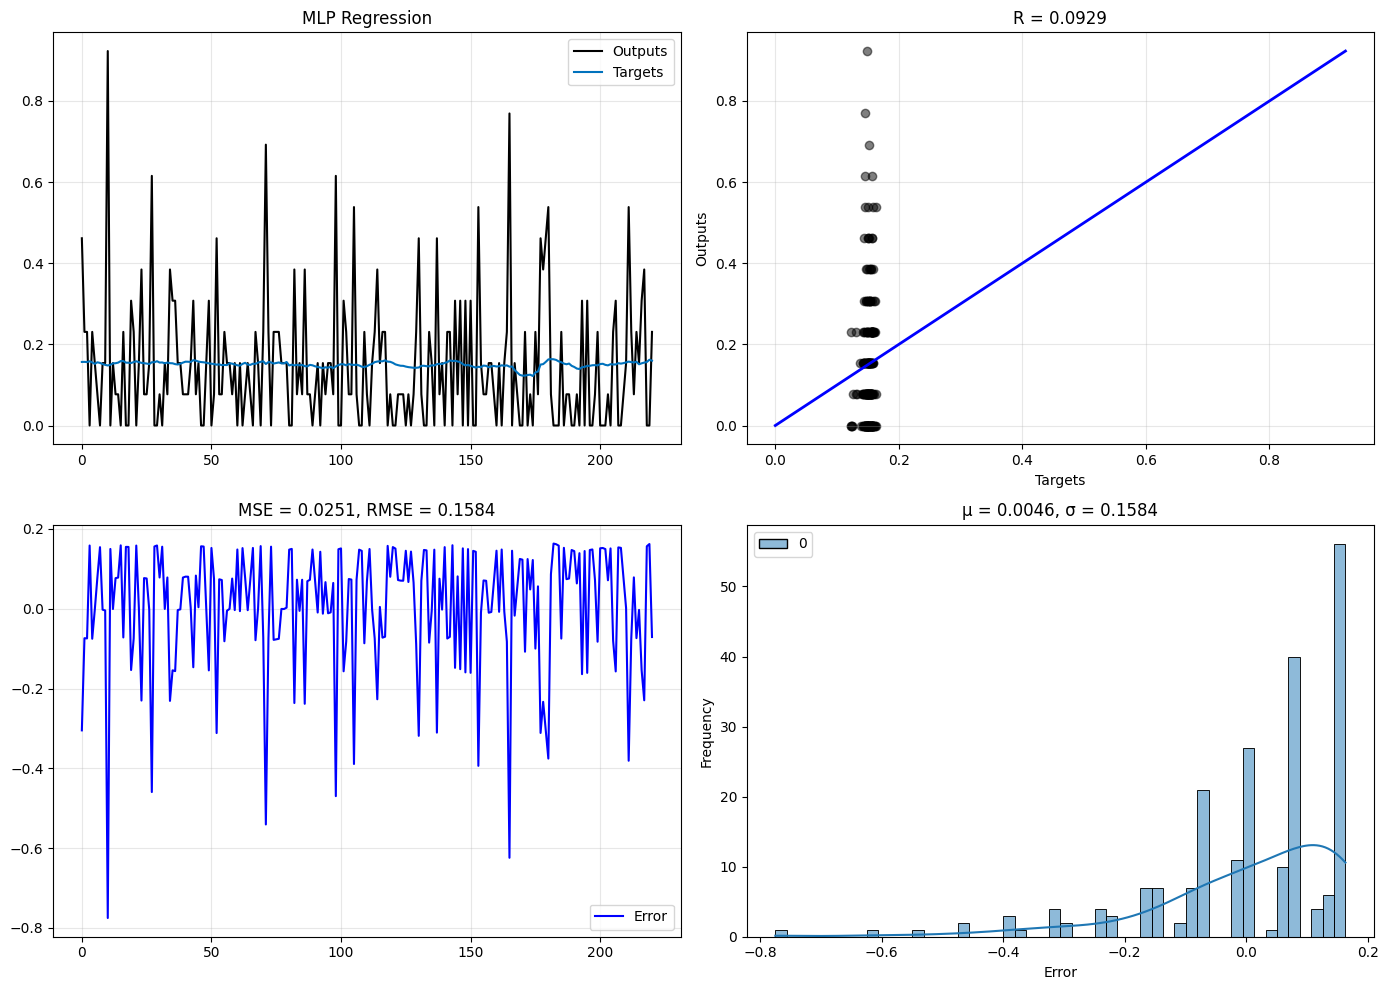

In [24]:
from utils import plot_results

plot_results(yhat, test_y, "MLP Regression")